# Multi-class Classification



## 0. Preliminaries

In [1]:
# Import statements
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs # , make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

from helper_functions import scatter_2D_class, plot_loss, plot_decision_boundary, accuracy_fn
from models import MultiClassificationModelV0, train_step_multi_classification, test_step_multi_classification

In [2]:
# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cpu


## 1. Construct, format, split and visualize data

In [ ]:
# Create linearly separable blobs data
if False:
    X, y = make_blobs(n_samples = 1000,
                      n_features = NUM_FEATURES,
                      centers = NUM_CLASSES,
                      cluster_std = 1.5,
                      random_state = RANDOM_SEED)

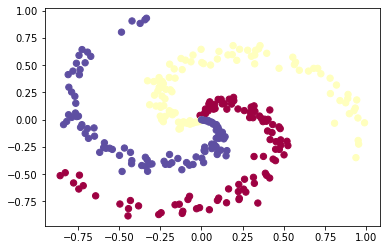

In [15]:
if True:
    # Code for creating a spiral dataset from CS231n
    import numpy as np
    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    # lets visualize the data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

In [22]:
X.shape, y.shape, type(X), type(y), X.dtype, y.dtype, X[:3], y[:3]

((300, 2),
 (300,),
 numpy.ndarray,
 numpy.ndarray,
 dtype('float64'),
 dtype('uint8'),
 array([[-0.        ,  0.        ],
        [ 0.00068516,  0.01007775],
        [-0.00161737,  0.02013717]]),
 array([0, 0, 0], dtype=uint8))

In [4]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)    # float32 decimal digit
y = torch.from_numpy(y).type(torch.ByteTensor) # unsigned 8-bit integer (can be ByteTensor, ShortTensor, IntTensor, LongTensor)

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_SEED)

(300, 2) (300,) float64 uint8


(array([[-0.        ,  0.        ],
        [ 0.00068516,  0.01007775],
        [-0.00161737,  0.02013717],
        [-0.00561597,  0.02977809],
        [-0.00864501,  0.03946835]]),
 array([0, 0, 0, 0, 0], dtype=uint8))

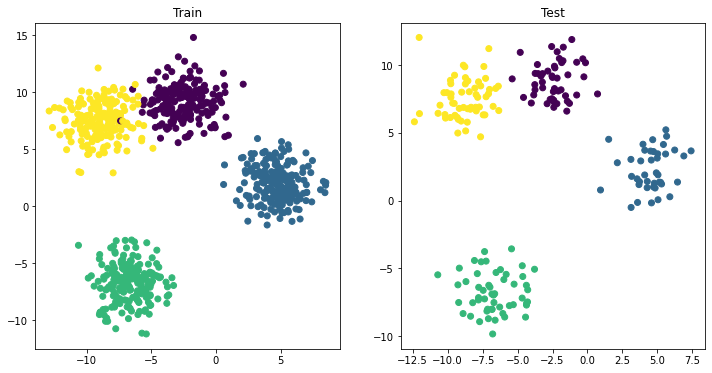

In [16]:
# Plot data and show a few samples

scatter_2D_class(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test)

print(X.shape, y.shape, X.dtype, y.dtype)

X[:5], y[:5]

## 2. Define model, loss and optimizer

Note: Model `MultiClassificationModelV0` defined in models.py

In [6]:
# Instantiate model

model0 = MultiClassificationModelV0(input_features=NUM_FEATURES,
                                   output_features=NUM_CLASSES,
                                   hidden_units=8,
                                   nonlin=None).to(device)

model0

MultiClassificationModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Identity()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Identity()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
# Create Loss function and optimizer

loss_fn = nn.CrossEntropyLoss() # for multi-class classification

optimizer = torch.optim.SGD(params=model0.parameters(),
                           lr=0.01)

## 3. Make predictions with untrained model

In [8]:
model0.eval()

with torch.inference_mode():
    y_logits = model0(X_test)
    
y_prob = torch.softmax(y_logits,dim=1) # convert logits to prediction probabilities
y_pred = torch.argmax(y_prob,dim=1) # find location of max after softmax

loss_untrained = loss_fn(y_logits, y_test)

acc_untrained = accuracy_fn(y_pred, y_test)

In [9]:
print(f"Untrained Model - Loss: {loss_untrained.item():.4f} | Accuracy: {acc_untrained.item():.4f}")

Untrained Model - Loss: 1.0030 | Accuracy: 0.6400


In [10]:
#y_prob.shape, y_prob[:3]

In [11]:
#y_pred.shape, y_pred[:3]

## 4. Train model

In [12]:
# Set up seeds for reproducability.
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)


epochs = 200
eval_freq = 10

epoch_count = []
loss_count = []
accuracy_count = []
test_loss_count = []
test_accuracy_count = []

for epoch in range(epochs):
    
    loss, acc = train_step_multi_classification(data = X_train, 
                                                labels = y_train, 
                                                model = model0, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
    
    if epoch % eval_freq == 0:
        
        test_loss, test_acc = test_step_multi_classification(data = X_test, 
                                                             labels = y_test, 
                                                             model = model0, 
                                                             loss_fn = loss_fn)
        
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        accuracy_count.append(acc)
        test_loss_count.append(test_loss.item())
        test_accuracy_count.append(test_acc)
        
        print(f"Epoch: {epoch:4d} | Loss: {loss:.4f} - Acc: {acc:.3f} | Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.3f}")

Epoch:    0 | Loss: 1.0531 - Acc: 0.626 | Test Loss: 0.9136 - Test Acc: 0.690
Epoch:   10 | Loss: 0.6041 - Acc: 0.939 | Test Loss: 0.5610 - Test Acc: 0.975
Epoch:   20 | Loss: 0.4520 - Acc: 0.981 | Test Loss: 0.4291 - Test Acc: 0.980
Epoch:   30 | Loss: 0.3586 - Acc: 0.989 | Test Loss: 0.3446 - Test Acc: 0.985
Epoch:   40 | Loss: 0.2947 - Acc: 0.990 | Test Loss: 0.2854 - Test Acc: 0.985
Epoch:   50 | Loss: 0.2490 - Acc: 0.991 | Test Loss: 0.2422 - Test Acc: 0.990
Epoch:   60 | Loss: 0.2151 - Acc: 0.991 | Test Loss: 0.2096 - Test Acc: 0.990
Epoch:   70 | Loss: 0.1891 - Acc: 0.991 | Test Loss: 0.1844 - Test Acc: 0.990
Epoch:   80 | Loss: 0.1688 - Acc: 0.991 | Test Loss: 0.1644 - Test Acc: 0.990
Epoch:   90 | Loss: 0.1525 - Acc: 0.991 | Test Loss: 0.1482 - Test Acc: 0.990
Epoch:  100 | Loss: 0.1392 - Acc: 0.991 | Test Loss: 0.1349 - Test Acc: 0.990
Epoch:  110 | Loss: 0.1282 - Acc: 0.990 | Test Loss: 0.1238 - Test Acc: 0.990
Epoch:  120 | Loss: 0.1189 - Acc: 0.990 | Test Loss: 0.1144 - Te

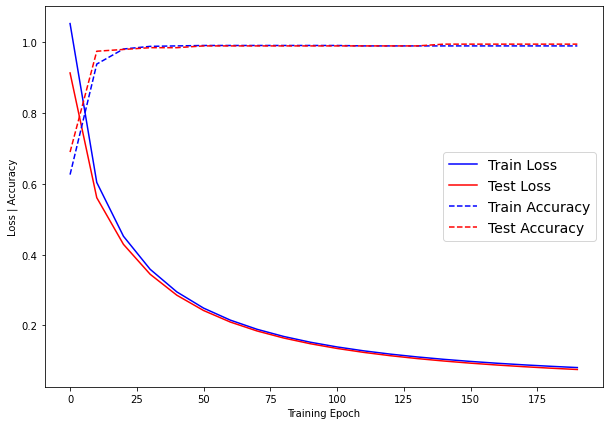

In [13]:
# Plot learning curves during training.

plot_loss(epoch=epoch_count, 
          loss=loss_count, 
          test_loss=test_loss_count,
          acc=accuracy_count,
          test_acc=test_accuracy_count)

Text(0.5, 1.0, 'Test')

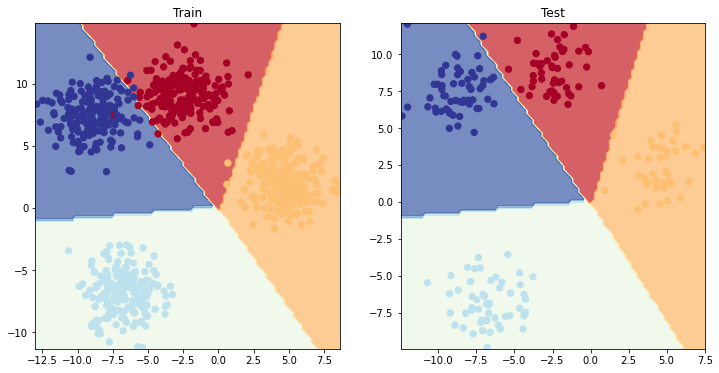

In [14]:
# Plot decision boundaries

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model=model0, 
                       X=X_train, 
                       y=y_train)
plt.title('Train')
plt.subplot(1,2,2)
plot_decision_boundary(model=model0, 
                       X=X_test, 
                       y=y_test)
plt.title('Test')